In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import RobustScaler
plt.style.use("bmh")
!pip install ta
import ta
from datetime import timedelta

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

  Created wheel for ta: filename=ta-0.7.0-py3-none-any.whl size=28716 sha256=b3d712187426fbd6529e4cd124091ccff5a608dafc9a68ae60d664dcd798fb5d
  Stored in directory: /root/.cache/pip/wheels/5e/74/e0/72395003bd1d3c8f3f5860c2d180ff15699e47a2733d8ebd38
Successfully built ta


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Group 6 - Stock Price Prediction Project (MSBA)/Code & New Datasets/May 2021/QQQ-201901-202104.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df = df[['Date', 'Time Interval',
         'Close', 'Net Chg', 'Open', 'High', 'Low',
         'Tick Count', 'Volume']]


In [ ]:
#Drop NA
df = df[df['Volume'] != 'N.A.']
df['Volume'] = df['Volume'].astype(float)


In [ ]:
# Datetime conversion
df['Date'] = pd.to_datetime(df.Date)

# Setting the index
df.set_index('Date', inplace=True)

In [ ]:
# Adding all the indicators
df = ta.add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)


/usr/local/lib/python3.7/dist-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/usr/local/lib/python3.7/dist-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [ ]:
# Checking the new df with indicators
print(df.shape)

df.head()

(226624, 91)


,Time Interval,Close,Net Chg,Open,High,Low,Tick Count,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,...,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-02,09:30 - 09:31,151.25,-3.01,150.990,151.320,150.88,1419.0,489044.0,333439.090909,489044.0,0.681818,0.000000,50.0,0.000000,0.000000,-171765.543237,1000.000000,151.150000,0.0,151.250000,151.250000,151.250000,0.000000,0.000000,0.0,0.0,151.150000,151.590000,150.710000,0.582203,0.613636,0.0,0.0,150.88,151.320,151.1000,0.290909,0.840909,0.0,0.000000,...,0.000000,-35.117798,1.000000,0.000000,81.882043,-351.226035,-351.226035,0.000000,151.1000,151.1000,151.1000,151.1000,233.111019,233.075845,4.0,4.0,0.0,-1.00,-1.00,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.000000,84.090909,84.090909,-15.909091,0.0,151.250000,0.0,0.000000,0.000000,0.000000,-35.122603,0.000000,0.000000
2019-01-02,09:31 - 09:32,151.48,0.23,151.250,151.620,151.25,1324.0,265464.0,398011.415233,754508.0,0.527511,61056.720000,100.0,46.691830,46.691830,-171361.304052,1001.520661,151.255551,0.0,151.365000,151.595000,151.135000,0.303901,0.750000,0.0,0.0,151.300000,151.705000,150.895000,0.535360,0.722222,0.0,0.0,150.88,151.620,151.2500,0.488884,0.810811,0.0,0.018348,...,0.008109,0.000297,1.974382,66.666667,81.767043,-350.732752,-350.979393,0.246641,151.2500,151.2500,151.2500,151.2500,233.111019,233.075845,8.0,4.0,4.0,-1.00,-1.00,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,28.395062,81.081081,82.585995,-18.918919,0.0,151.351296,0.0,-3.774836,-0.754967,-3.019869,0.152066,0.151951,0.152066
2019-01-02,09:32 - 09:33,151.48,0.00,151.470,151.700,151.47,1054.0,162868.0,249305.850016,917376.0,0.271760,52334.331429,100.0,21.182798,33.937314,403.680793,1001.520661,151.307827,0.0,151.403333,151.620179,151.186487,0.286448,0.676777,0.0,0.0,151.383333,151.730000,151.036667,0.457998,0.639423,0.0,0.0,150.88,151.700,151.2900,0.541600,0.731707,0.0,0.032513,...,0.011708,0.000780,2.879983,71.428571,81.728710,-350.568324,-350.842370,0.274046,151.2900,151.2900,151.2900,151.2900,233.111019,233.075845,8.0,4.0,4.0,-1.00,151.32,0.0,1.0,0.0,100.0,0.0,0.0,0.0,100.0,23.076923,73.170732,79.447574,-26.829268,0.0,151.407963,0.0,-8.851138,-2.374201,-6.476936,0.000000,0.000000,0.152066
2019-01-02,09:33 - 09:34,151.59,0.11,151.475,151.700,151.38,1249.0,227503.0,320400.537516,1144879.0,0.279855,48433.045510,100.0,-6.329587,20.515014,165.205506,1001.520661,151.357275,0.0,151.450000,151.697790,151.202210,0.327224,0.782497,0.0,0.0,151.426667,151.766667,151.086667,0.449062,0.740196,0.0,0.0,150.88,151.700,151.2900,0.541433,0.865854,0.0,0.052016,...,0.010580,0.001506,3.776847,62.650602,81.682043,-350.368152,-350.723816,0.355664,151.2900,151.2900,151.2900,151.2900,233.111019,233.075845,16.0,4.0,12.0,151.47,151.32,1.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,33.088235,86.585366,80.279060,-13.414634,0.0,151.487961,0.0,-11.863663,-4.272094,-7.591570,0.072617,0.072590,0.224793
2019-01-02,09:34 - 09:35,151.65,0.06,151.600,151.775,151

In [ ]:
# Dropping everything else besides 'Close' and the Indicators
df.drop(['Time Interval'], axis=1, inplace=True)

In [ ]:
# Scale fitting the close prices separately for inverse_transformations purposes later
close_scaler = RobustScaler()

close_scaler.fit(df[['Close']])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [ ]:
# Normalizing/Scaling the Data
scaler = RobustScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

df.tail(10)

,Close,Net Chg,Open,High,Low,Tick Count,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,volume_vwap,volatility_atr,volatility_bbm,volatility_bbh,volatility_bbl,volatility_bbw,volatility_bbp,volatility_bbhi,volatility_bbli,volatility_kcc,volatility_kch,volatility_kcl,volatility_kcw,volatility_kcp,volatility_kchi,volatility_kcli,volatility_dcl,volatility_dch,volatility_dcm,volatility_dcw,volatility_dcp,volatility_ui,trend_macd,trend_macd_signal,...,trend_vortex_ind_diff,trend_trix,trend_mass_index,trend_cci,trend_dpo,trend_kst,trend_kst_sig,trend_kst_diff,trend_ichimoku_conv,trend_ichimoku_base,trend_ichimoku_a,trend_ichimoku_b,trend_visual_ichimoku_a,trend_visual_ichimoku_b,trend_aroon_up,trend_aroon_down,trend_aroon_ind,trend_psar_up,trend_psar_down,trend_psar_up_indicator,trend_psar_down_indicator,trend_stc,momentum_rsi,momentum_stoch_rsi,momentum_stoch_rsi_k,momentum_stoch_rsi_d,momentum_tsi,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-04-30,1.303976,0.00,1.303898,1.304205,1.303664,3.470060,3.108179,0.787231,0.658917,-0.798648,0.207589,-0.768335,-6.043071e-01,-0.603524,-2.121148,2.713576,1.304396,0.566151,1.305984,1.304841,1.306916,0.159484,-0.411251,0.0,0.0,1.303726,1.303234,1.304053,0.149306,0.037668,0.0,0.0,1.306450,1.304052,1.304975,0.097397,-0.242573,0.576224,-0.789567,-0.602106,...,-0.786303,-0.382099,0.362333,-0.409015,0.782411,-0.363951,-0.065028,-0.905501,1.303799,1.305815,1.304786,1.307256,1.305966,1.308084,-0.588235,0.647059,-0.821429,1.302311,1.304101,0.0,0.0,-0.510535,-0.415703,0.034840,0.020979,-0.267937,-0.624301,-0.234898,-0.224105,-0.193712,-0.224105,-0.931534,1.303342,-0.696998,2.276690,1.707657,1.835626,0.000000,0.000000,1.303976
2021-04-30,1.303768,-0.20,1.303690,1.303790,1.304598,1.655689,1.332311,0.786690,0.658410,-0.911453,-0.021392,-0.558547,1.528607e-01,-0.619351,-0.265712,2.713314,1.304263,0.540017,1.305735,1.304453,1.306806,0.130620,-0.412882,0.0,0.0,1.303534,1.303126,1.303778,0.195071,0.029982,0.0,0.0,1.306450,1.304052,1.304975,0.097470,-0.279892,0.598961,-0.765922,-0.641935,...,-0.765255,-0.419331,0.512474,-0.357404,0.530133,-0.414678,-0.143629,-0.824023,1.303799,1.305815,1.304786,1.307256,1.306330,1.308084,-0.647059,0.588235,-0.821429,1.302462,1.304101,0.0,0.0,-0.510660,-0.463939,0.140028,0.053178,-0.065539,-0.612121,-0.196054,-0.190954,-0.221211,-0.190954,-0.798116,1.303380,-0.588173,1.986524,1.833465,0.989419,-0.134064,-0.134071,1.303768
2021-04-30,1.303457,-0.30,1.303690,1.302856,1.303664,1.443114,1.339345,0.786871,0.657902,-0.734901,-0.316502,-0.599666,-5.483984e-01,-0.556055,-0.655426,2.713314,1.304068,0.516496,1.305546,1.304268,1.306613,0.131322,-0.436430,0.0,0.0,1.303320,1.302911,1.303563,0.195145,0.003445,0.0,0.0,1.306450,1.304052,1.304975,0.097526,-0.335870,0.610159,-0.758996,-0.672341,...,-0.749977,-0.449668,0.642357,-0.449725,0.342677,-0.461871,-0.220315,-0.737439,1.303799,1.305815,1.304786,1.307256,1.306330,1.308084,-0.705882,0.529412,-0.821429,1.302609,1.304101,0.0,0.0,-0.510722,-0.538223,0.220091,0.152828,0.081399,-0.614387,-0.154916,-0.221457,-0.220278,-0.221457,-0.644828,1.303399,-0.533770,1.741493,1.875572,0.389713,-0.201107,-0.201121,1.303457
2021-04-30,1.303716,0.25,1.303275,1.302649,1.303871,1.574850,1.186685,0.787454,0.658372,-0.590242,-0.047947,-0.423114,-6.581167e-13,-0.435441,-0.096079,2.713641,1.303957,0.467001,1.305351,1.303993,1.306498,0.114661,-0.352551,0.0,0.0,1.303218,1.302840,1.303430,0.212320,0.100319,0.0,0.0,1.306450,1.304052,1.304975,0.097584,-0.289222,0.606044,-0.729784,-0.690520,...,-0.694281,-0.471483,0.727067,-0.401908,0.018570,-0.490901,-0.288670,-0.620063,1.303799,1.305815,1.304786,1.306580,1.306018,1.308084,-0.764706,0.470588,-0.821429,1.302754,1.304101,0.0,0.0,-0.510754,-0

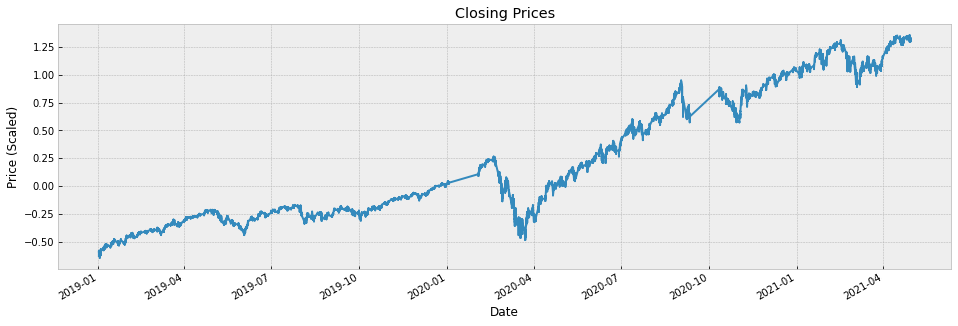

In [ ]:
# Plotting the Closing Prices
df['Close'].plot(figsize=(16,5))
plt.title("Closing Prices")
plt.ylabel("Price (Scaled)")
plt.show()

In [ ]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the multivariate time sequence
    """
    
    # Creating a list for both variables
    X, y = [], []
    
    for i in range(len(seq)):
        
        # Finding the end of the current sequence
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        # Breaking out of the loop if we have exceeded the dataset's length
        if out_end > len(seq):
            break
        
        # Splitting the sequences into: x = past prices and indicators, y = prices ahead
        seq_x, seq_y = seq[i:end, :], seq[end:out_end, 0]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [ ]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [ ]:
def layer_maker(n_layers, n_nodes, activation, drop=None, d_rate=.5):
    """
    Creates a specified number of hidden layers for an RNN
    Optional: Adds regularization option - the dropout layer to prevent potential overfitting (if necessary)
    """
    
    # Creating the specified number of hidden layers with the specified number of nodes
    for x in range(1,n_layers+1):
        model.add(LSTM(n_nodes, activation=activation, return_sequences=True))

        # Adds a Dropout layer after every Nth hidden layer (the 'drop' variable)
        try:
            if x % drop == 0:
                model.add(Dropout(d_rate))
        except:
            pass

In [ ]:
def validater(n_per_in, n_per_out):
    """
    Runs a 'For' loop to iterate through the length of the DF and create predicted values for every stated interval
    Returns a DF containing the predicted values for the model with the corresponding index values based on a business day frequency
    """
    
    # Creating an empty DF to store the predictions
    predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])

    for i in range(1, len(df)-n_per_in, n_per_out):
        # Creating rolling intervals to predict off of
        x = df[-i - n_per_in:-i]

        # Predicting using rolling intervals
        yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))

        # Transforming values back to their normal prices
        yhat = close_scaler.inverse_transform(yhat)[0]

        # DF to store the values and append later, frequency uses business days
        pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1]+timedelta(days=1), 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

        # Updating the predictions DF
        predictions.update(pred_df)
        
    return predictions


In [ ]:
predictions = pd.DataFrame(index=df.index, columns=[df.columns[0]])


In [ ]:
for i in range(1, len(df)-n_per_in, n_per_out):
    x = df[-i - n_per_in:-i]

In [ ]:
yhat = model.predict(np.array(x).reshape(1, n_per_in, n_features))


In [ ]:
 yhat = close_scaler.inverse_transform(yhat)[0]

In [ ]:
pred_df = pd.DataFrame(yhat, 
                               index=pd.date_range(start=x.index[-1]+timedelta(days=1), 
                                                   periods=len(yhat), 
                                                   freq="B"),
                               columns=[x.columns[0]])

In [ ]:
predictions.update(pred_df)

In [ ]:
predictions=validater(60,1)

In [ ]:
def val_rmse(df1, df2):
    """
    Calculates the root mean square error between the two Dataframes
    """
    df = df1.copy()
    
    # Adding a new column with the closing prices from the second DF
    df['close2'] = df2.Close
    
    # Dropping the NaN values
    df.dropna(inplace=True)
    
    # Adding another column containing the difference between the two DFs' closing prices
    df['diff'] = df.Close - df.close2
    
    # Squaring the difference and getting the mean
    rms = (df[['diff']]**2).mean()
    
    # Returning the sqaure root of the root mean square
    return float(np.sqrt(rms))

In [ ]:

# How many periods looking back to learn
n_per_in  = 60

# How many periods to predict
n_per_out = 1

# Features 
n_features = df.shape[1]

# Splitting the data into appropriate sequences
X, y = split_sequence(df.to_numpy(), n_per_in, n_per_out)

In [ ]:
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(60, 
               activation=activ, 
               return_sequences=True, 
               input_shape=(n_per_in, n_features)))

# Hidden layers
layer_maker(n_layers=2, 
            n_nodes=30, 
            activation=activ,
            drop=1,
            d_rate=.1)

# Final Hidden layer
model.add(LSTM(60, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 60)            36240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 30)            10920     
_________________________________________________________________
dropout (Dropout)            (None, 60, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 30)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60)                21840     
_________________________________________________________________
dense (Dense)                (None, 1)                 6

In [ ]:
# Compiling the data with selected specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) #metrics=mse


In [ ]:
res = model.fit(X, y, epochs=100, batch_size=32, validation_split=0.1)

Epoch 1/20
6373/6373 [==============================] - 725s 110ms/step - loss: 0.0027 - accuracy: 5.8969e-05 - val_loss: 0.0020 - val_accuracy: 0.0000e+00
Epoch 2/20
6373/6373 [==============================] - 720s 113ms/step - loss: 1.8811e-04 - accuracy: 6.9514e-05 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 3/20
6373/6373 [==============================] - 682s 107ms/step - loss: 9.0527e-05 - accuracy: 6.8831e-05 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 4/20
6373/6373 [==============================] - 679s 107ms/step - loss: 6.6287e-05 - accuracy: 7.1809e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/20
6373/6373 [==============================] - 679s 106ms/step - loss: 5.7752e-05 - accuracy: 5.6502e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/20
6373/6373 [==============================] - 675s 106ms/step - loss: 4.8964e-05 - accuracy: 6.4624e-05 - val_loss: 0.0013 - val_accuracy: 0.0000e+00
Epoch 7/20
6373/6373 [======================

In [ ]:
print("RMSE:", val_rmse(actual, pred_df))

RMSE: 2.2708976376839183


In [ ]:
# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]]), 
                      index=df.index, 
                      columns=[df.columns[0]])

# Getting a DF of the predicted values to validate against
predictions = pred_df
# Printing the RMSE
print("RMSE:", val_rmse(actual, predictions))
    
# Plotting
plt.figure(figsize=(16,6))

# Plotting those predictions
plt.plot(predictions, label='Predicted')

# Plotting the actual values
plt.plot(actual, label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.xlim('2019-01', '2021-04')
plt.show()

                 Close
2021-05-03  331.063232


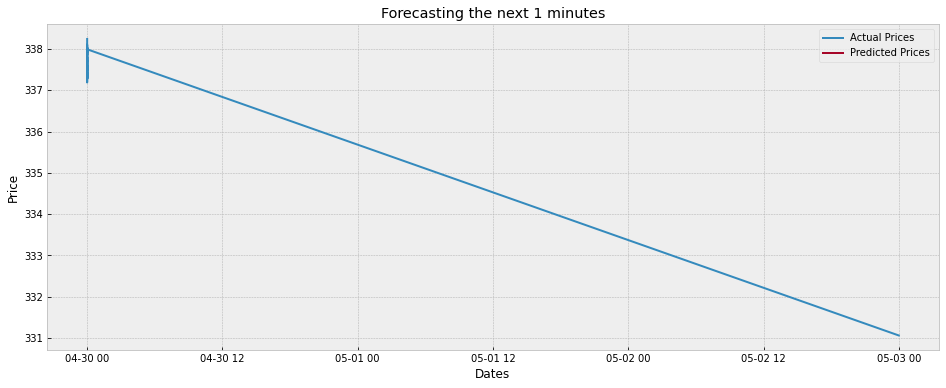

In [ ]:
# Predicting off of the most recent days from the original DF
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features))

# Transforming the predicted values back to their original format
yhat = close_scaler.inverse_transform(yhat)[0]

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, 
                     index=pd.date_range(start=df.index[-1]+timedelta(days=1), 
                                         periods=len(yhat), 
                                         freq="B"), 
                     columns=[df.columns[0]])

# Number of periods back to plot the actual values
pers = n_per_in

# Transforming the actual values to their original price
actual = pd.DataFrame(close_scaler.inverse_transform(df[["Close"]].tail(pers)), 
                      index=df.Close.tail(pers).index, 
                      columns=[df.columns[0]]).append(preds.head(1))

# Printing the predicted prices
print(preds)

# Plotting
plt.figure(figsize=(16,6))
plt.plot(actual, label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} minutes")
plt.legend()
plt.show()